In [43]:
import mat73
import matplotlib.pyplot as plt
import numpy as np

In [44]:
data = mat73.loadmat('focused_transmit1.mat')

In [45]:
data['rf'].shape

(1920, 128, 128)

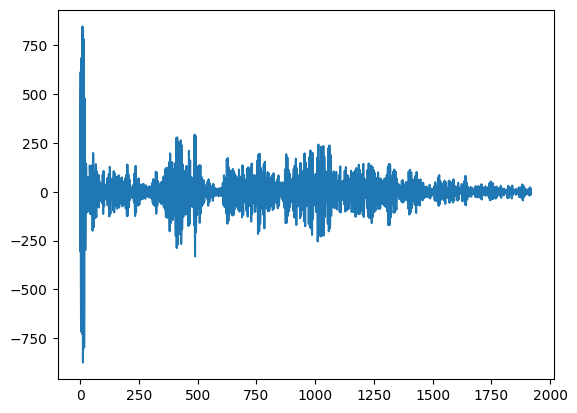

In [46]:
plt.plot(range(1920),data['rf'][:,0,0])

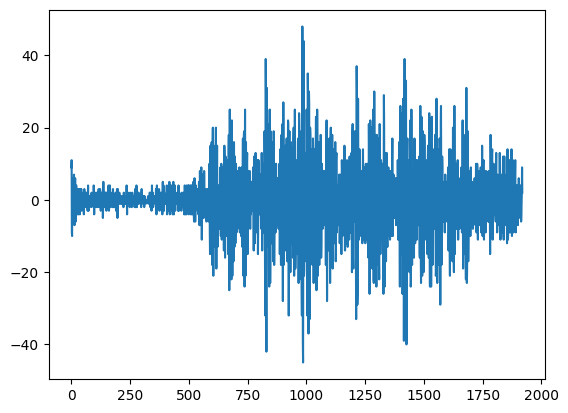

In [47]:
plt.plot(range(1920),data['rf'][:,0,127])

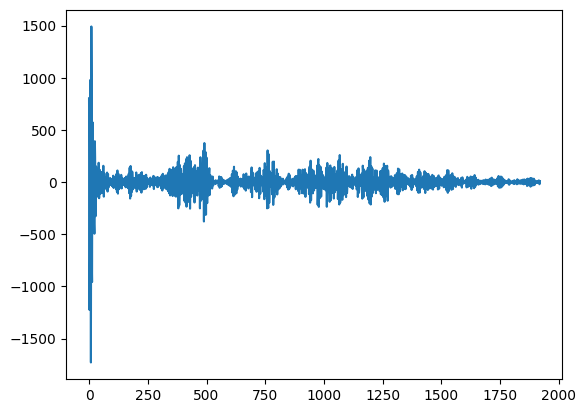

In [48]:
plt.plot(range(1920),data['rf'][:,1,2])

In [49]:
time_range=[]
for i in range(1,1921):
    time_range.append(i*(1/(20.833*10**6)))

In [50]:
lst=list(range(1920))

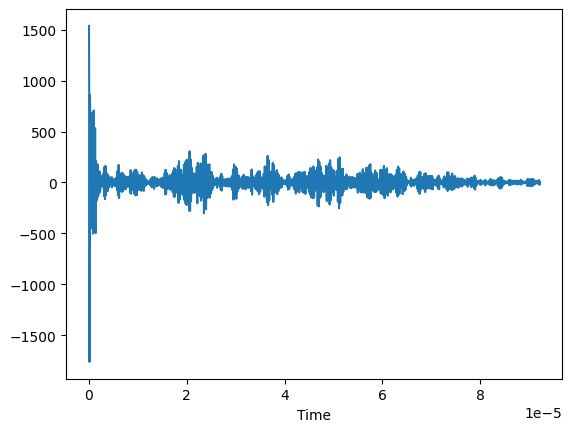

In [51]:
plt.plot(time_range, data['rf'][:,1,1])
plt.xlabel("Time")
plt.show()




In [52]:
#distance component 
#WAVELENGTH IS v=freq * wavelength
#distance= speed (1452) * time
#/2 cause the factor of 2 indicates the time it takes to go and echo back - we just want depth
#+5 wavelength cause its specified

wavelength=1452/(5.208*10**6)
distance=[5*wavelength+((x*1452)/2) for x in time_range] #Time_range



# Band Pass Filter

In [145]:
fractional_bw=0.55
frequency=5.208*10**6
sampling_frequency=20.833*10**6
high=frequency + (fractional_bw/2)*(frequency)
low=frequency - (fractional_bw/2)*(frequency)

count=0

for image_line in range(128):
    for t_element in range(128):
        
        #Convert to frequency Domain
        sig=np.fft.fft(data['rf'][:,image_line,t_element])
        #freq=np.fft.fftfreq(np.array(time_range).shape[0]/)
        
        n=len(sig)
        T=n/sampling_frequency
        f=np.arange(n)/T
        f=f-(1*10**7)
        filtered_frequency=[]
        signal=[]
        
        #Bandpass filter
        for i,j in zip(f,sig):
            if i>=low and i<=high:
                filtered_frequency.append(i)
                signal.append(j)
            else:
                signal.append(0)
                filtered_frequency.append(i)

        signal=np.array(signal)
        print(signal)
        #new_time_range=np.arange(1,len(filtered_frequency)+1)*(1/np.array(filtered_frequency))

        new_signal=np.array(np.fft.ifft((signal)))
        
        if count==0:
            final_signal=new_signal
            count+=1
        else:
            final_signal=np.vstack((final_signal,new_signal))

# Single element B-Mode Image formation

In [53]:
#single element image formation
for i in range(128):
    if i==0:
        single_element=data['rf'][:,i,i].reshape(1920,1)
    else:
        single_element=np.hstack((single_element, data['rf'][:,i,i].reshape(1920,1)))


In [54]:
single_element.shape

(1920, 128)

In [55]:
data_1 = [np.abs(x) for x in single_element]
comp_line = [x**0.4 for x in data_1]

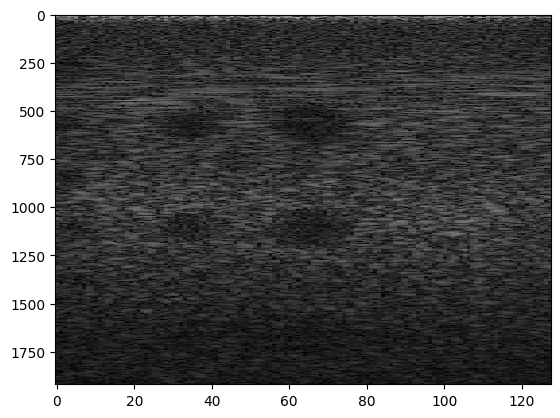

In [56]:

plt.imshow(comp_line, interpolation='nearest', aspect='auto', cmap='gray')

# Starting of the actual code

In [72]:
#trying to find the delay (time it takes from focal length 2.8 cm to each element for first line)
element_spacing=0.298*10**-3
n_elements=128
beam_spacing=0.298*10**-3
focal_length=2.8*10**-2
#f/2 receieve apetrure means  #=depth/apeture, apeture= 1.5 cm given 3 cm depth
#have 

In [73]:
#to find the number of elements that needs to be summed (apeture)
import math
d=0.75*10**-2
print("Number of Elements that need to be summed from each side:",math.floor(d/element_spacing))

Number of Elements that need to be summed from each side: 25


In [74]:
import math

def distance_delay_upsample_offset_sum(element_spacing, n_elements, beam_spacing, focal_length,d):
    count=0
    upsampling_factor=10
    final_image=[]

    for line in range(0,128):
        distances=[]
        if line-25<0:
            low=0
        else:
            low=line-25
        if line+25>127:
            high=127
        else:
            high=line+25

        for e in range(low,high+1):
            if e==line:
                distances.append(focal_length)
            else:
                distances.append(math.sqrt((np.abs(e-line)*element_spacing)**2 + (focal_length)**2))

        #NOW I HAVE THE DISTANCES FOR THE RESPECTIVE ELEMENTS TO THE FOCAL LENGTH FOR EACH ELEMENT TO SPECIFIC LINE "LINE"

        #STORED IN DISTANCES

        #NOW CALCULATING THE DELTA DISTANCE USED TO CALCULATE THE DELAY
        delta_x=[x-focal_length for x in distances]
        delta_x
        #NOW CALCULATING THE TIME DELAY TO FOCAL POINT FOR ALL THE SPECIFIC ELEMENTS TO THAT POINT
        time_from_focal=[x/1452 for x in delta_x]


        #UPSAMPLING THE DATA BY A FACTOR OF 10
        for ele in range(low,high+1):
            data_points_upsampled=[]
            time_range_upsampled=[]

            for i in range(len(data['rf'])):
                data_points_upsampled.append(data['rf'][:,line,ele][i])
                time_range_upsampled.append(time_range[i])
                if i == len(data['rf'])-1:
                    break
                new_point=data['rf'][:,line,ele][i]
                new_time=time_range[i]
                delta=(data['rf'][:,line,ele][i+1]-data['rf'][:,line,ele][i])/upsampling_factor
                delta_time=(time_range[i+1]-time_range[i])/upsampling_factor

                for _ in range(upsampling_factor-1):
                    new_point=new_point+delta
                    new_time=new_time+delta_time
                    data_points_upsampled.append(new_point)
                    time_range_upsampled.append(new_time)

            data_points_upsampled=np.array(data_points_upsampled).T
            if ele==low:
                final_data_points_upsampled  = data_points_upsampled
            else:
                final_data_points_upsampled = np.vstack((final_data_points_upsampled,data_points_upsampled))
        #print(final_data_points_upsampled.shape)

        #OFFSETTING THE SIGNAL
        for i in range(0,len(final_data_points_upsampled)):
            if i==0:
                final=final_data_points_upsampled[0]
            else:
                time_range_upsampled = np.asarray(time_range_upsampled)
                idx = (np.abs(time_range_upsampled - time_from_focal[i])).argmin()

                temp=final_data_points_upsampled[i][idx:]
                temp1=np.pad(temp, (0, idx), 'constant')

                final=np.vstack((final,temp1))
        #SUMMATION of the respective element signals 
        final_image.append(final.sum(axis=0))
    
    for i in range(len(final_image)):
        temp=final_image[i].reshape(final_data_points_upsampled.shape[1],1)
        if i==0:
            image=final_image[i]
        else:
            image=image.reshape(final_data_points_upsampled.shape[1],i)
            image=np.hstack((image, temp))
    return image,time_range_upsampled



# TGC

In [75]:
import numpy as np
def tgc(image):
    np_per_db = 1/(20*np.log10(np.exp(1)))
    adb=0.01
    z= element_spacing*np.array([i for i in range(0, image.shape[1])])

    image_tgc = image.real
    for beam in range(0, image.shape[0]):
        image_tgc[beam] = np.multiply(image[beam].real, np.exp(adb*z))
    return image_tgc


# Envolope Detection

In [76]:
from scipy.signal import hilbert
def envelope_detection(image):
    env_temp1 = hilbert(image, N=None, axis=-1)
    env_data = np.absolute(env_temp1)
    return env_data

# Log Compression

In [77]:
def log_compression(image, x):
    scaled_image = image/image.max()
    comp_line = np.exp(x*np.log(scaled_image))
    return comp_line

In [78]:
#data_1 = [np.abs(x) for x in image]
#comp_line = [x**0.2 for x in data_1]

# Plot the Image

In [115]:
element_spacing=0.298*10**-3
n_elements=128
beam_spacing=0.298*10**-3
focal_length=2.8*10**-2
d=0.75*10**-2
comp_val=0.2

image,time_range_upsampled=distance_delay_upsample_offset_sum(element_spacing,n_elements, beam_spacing, focal_length,d)
image=tgc(image)
image=envelope_detection(image)
image=log_compression(image,0.8)

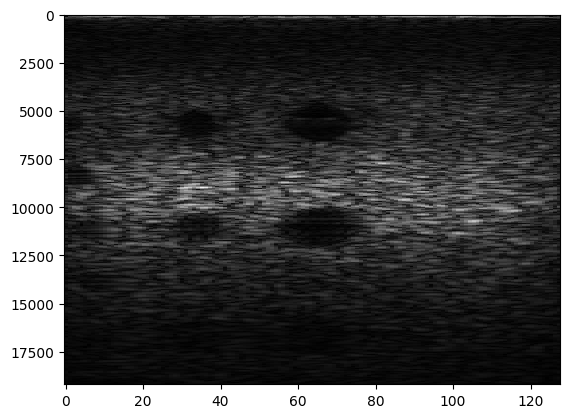

In [116]:
plt.imshow(image, interpolation='nearest', aspect='auto', cmap='gray')

# Dynamic Focusing

Focal Length:  0.0014288577741667827


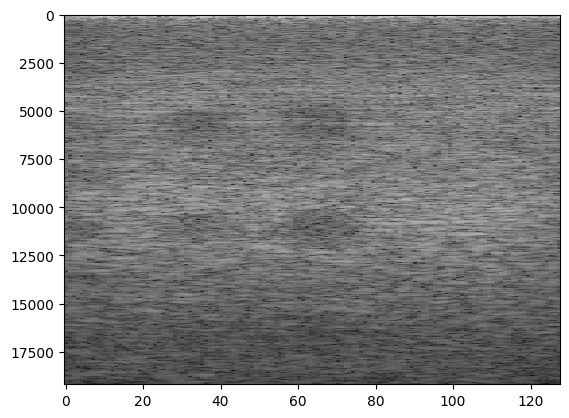

Focal Length:  0.014803734172189158


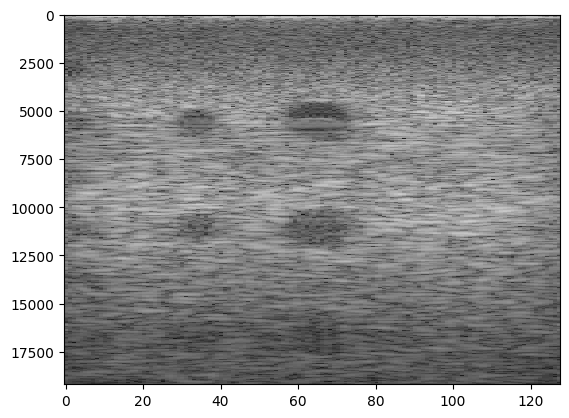

Focal Length:  0.02817861057021151


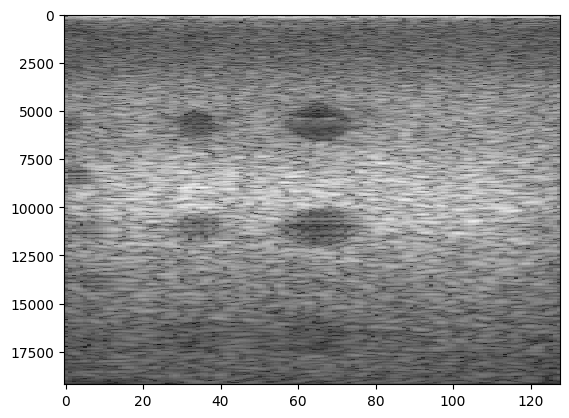

Focal Length:  0.04155348696823388


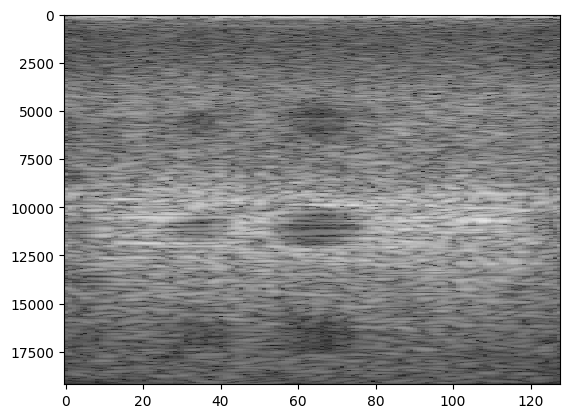

Focal Length:  0.054928363366256255


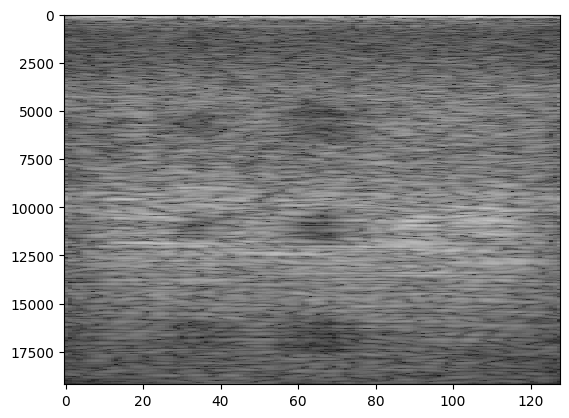

In [81]:
no_focal_points=5
wavelength=1452/(5.208*10**6)
distance=[5*wavelength+((x*1452)/2) for x in time_range_upsampled] #Time_range
for idx in range(0,len(distance),math.floor(len(distance)/no_focal_points)):

    element_spacing=0.298*10**-3
    n_elements=128
    beam_spacing=0.298*10**-3
    focal_length=distance[idx]
    d=0.75*10**-2

    image,time_range_upsampled=distance_delay_upsample_offset_sum(element_spacing,n_elements, beam_spacing, focal_length,d)
    image=tgc(image)
    image=envelope_detection(image)
    image=log_compression(image,comp_val)
    
    if idx==len(distance)-math.floor(len(distance)/no_focal_points)-1:
        end=math.floor(len(distance)/no_focal_points)+2
    else:
        end=math.floor(len(distance)/no_focal_points)+1
        
    #Last Row
    if idx==len(distance)-1:
        break
        

    #Storing the parts
    if idx==0:     
        mergered_image=image[idx:idx+end-1,:]
    else:
        
        mergered_image=np.vstack((mergered_image,image[idx:idx+end-1,:]))
        
    print("Focal Length: ", str(focal_length))
    plt.imshow(image, interpolation='nearest', aspect='auto', cmap='gray')
    plt.show()

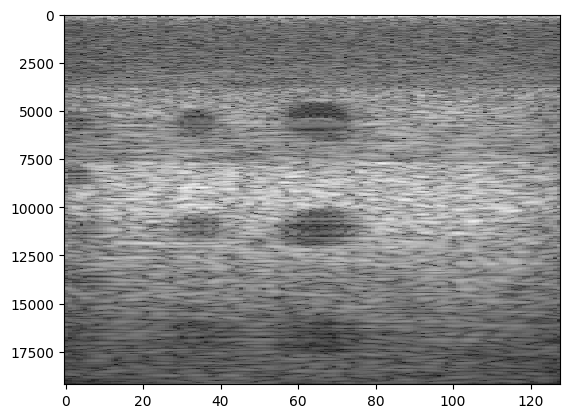

In [82]:
plt.imshow(mergered_image, interpolation='nearest', aspect='auto', cmap='gray')


# Apodization

In [98]:
import math

def distance_delay_upsample_offset_apodization_sum(element_spacing, n_elements, beam_spacing, focal_length,d,apodization,left_right=False):
    count=0
    upsampling_factor=10
    final_image=[]

    for line in range(0,128):
        distances=[]
        if line-25<0:
            low=0
        else:
            low=line-25
        if line+25>127:
            high=127
        else:
            high=line+25

        for e in range(low,high+1):
            if e==line:
                distances.append(focal_length)
            else:
                distances.append(math.sqrt((np.abs(e-line)*element_spacing)**2 + (focal_length)**2))

        #NOW I HAVE THE DISTANCES FOR THE RESPECTIVE ELEMENTS TO THE FOCAL LENGTH FOR EACH ELEMENT TO SPECIFIC LINE "LINE"

        #STORED IN DISTANCES

        #NOW CALCULATING THE DELTA DISTANCE USED TO CALCULATE THE DELAY
        delta_x=[x-focal_length for x in distances]
        delta_x
        #NOW CALCULATING THE TIME DELAY TO FOCAL POINT FOR ALL THE SPECIFIC ELEMENTS TO THAT POINT
        time_from_focal=[x/1452 for x in delta_x]


        #UPSAMPLING THE DATA BY A FACTOR OF 10
        for ele in range(low,high+1):
            data_points_upsampled=[]
            time_range_upsampled=[]

            for i in range(len(data['rf'])):
                data_points_upsampled.append(data['rf'][:,line,ele][i])
                time_range_upsampled.append(time_range[i])
                if i == len(data['rf'])-1:
                    break
                new_point=data['rf'][:,line,ele][i]
                new_time=time_range[i]
                delta=(data['rf'][:,line,ele][i+1]-data['rf'][:,line,ele][i])/upsampling_factor
                delta_time=(time_range[i+1]-time_range[i])/upsampling_factor

                for _ in range(upsampling_factor-1):
                    new_point=new_point+delta
                    new_time=new_time+delta_time
                    data_points_upsampled.append(new_point)
                    time_range_upsampled.append(new_time)

            data_points_upsampled=np.array(data_points_upsampled).T
            if ele==low:
                final_data_points_upsampled  = data_points_upsampled
            else:
                final_data_points_upsampled = np.vstack((final_data_points_upsampled,data_points_upsampled))
        print(final_data_points_upsampled.shape)

        #FOR APODIZATION, WE HAVE TO SUBSET THE APODIZATION ARRAY TO THE LENGTH OF THE FINAL_DATA_POINT_UPSAMPLED
        #checking if it is to the left or to the right
        
        if (len(final_data_points_upsampled)==51):
            left_right=True
            
        if left_right==True and len(final_data_points_upsampled)!=51:
            apodization_signal=apodization[:len(final_data_points_upsampled)]
            
        else:
            apodization_signal=apodization[len(apodization)-len(final_data_points_upsampled):]
        
        #when coming back down the signal (towards the elemnents right of the transducer)
        
        
        
        #OFFSETTING THE SIGNAL
        for i in range(0,len(final_data_points_upsampled)):
            if i==0:
                final=final_data_points_upsampled[0]
            else:
                time_range_upsampled = np.asarray(time_range_upsampled)
                idx = (np.abs(time_range_upsampled - time_from_focal[i])).argmin()

                temp=final_data_points_upsampled[i][idx:]
                temp1=np.pad(temp, (0, idx), 'constant')

                
                #ADDING APODIZATION HERE TO TEMP1 
                temp1=temp1*apodization_signal[i]
                
                
                final=np.vstack((final,temp1))
        #SUMMATION of the respective element signals 
        final_image.append(final.sum(axis=0))
    
    for i in range(len(final_image)):
        temp=final_image[i].reshape(final_data_points_upsampled.shape[1],1)
        if i==0:
            image=final_image[i]
        else:
            image=image.reshape(final_data_points_upsampled.shape[1],i)
            image=np.hstack((image, temp))
    return image




In [104]:
element_spacing=0.298*10**-3
n_elements=128
beam_spacing=0.298*10**-3
focal_length=2.8*10**-2
d=0.75*10**-2

x = np.linspace(-np.pi,np.pi,51) 
apodization=np.cos(x)


image=distance_delay_upsample_offset_apodization_sum(element_spacing,n_elements, beam_spacing, focal_length,d,apodization,left_right=False)

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

In [105]:
image=tgc(image)
image=envelope_detection(image)

image=log_compression(image,0.6)



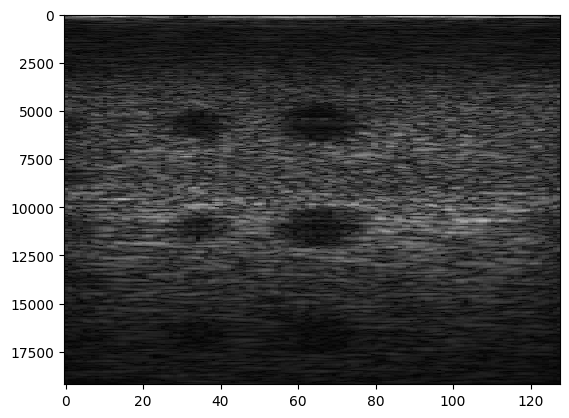

In [106]:

plt.imshow(image, interpolation='nearest', aspect='auto', cmap='gray')

## Apodization with Dynamic

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

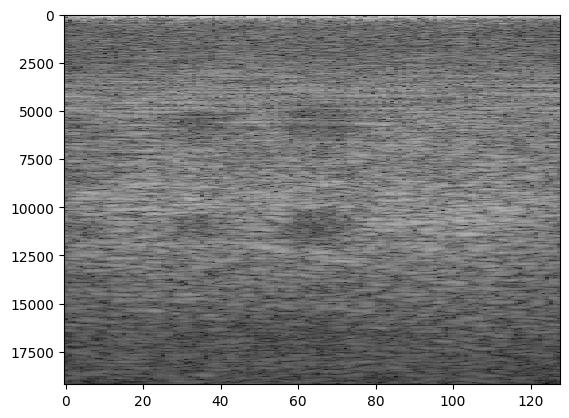

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

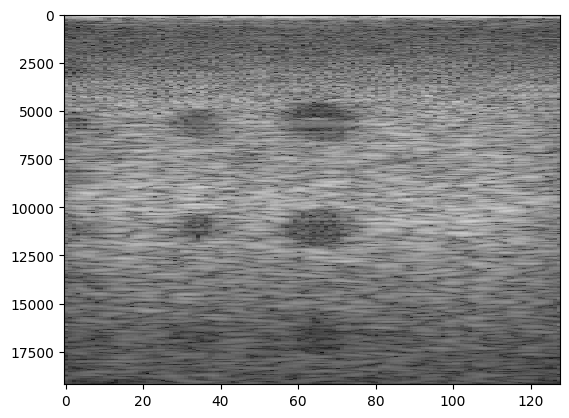

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

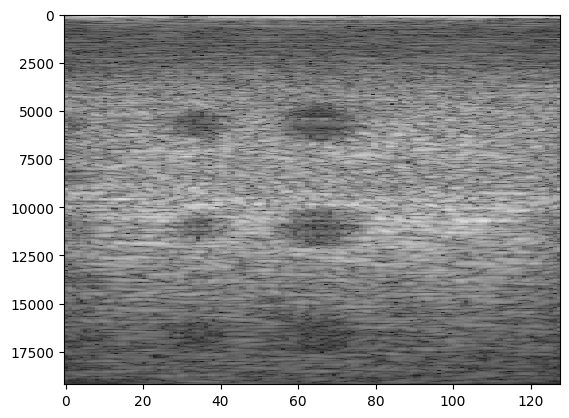

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

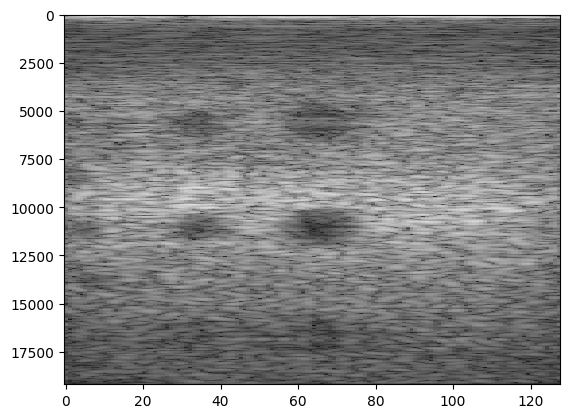

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

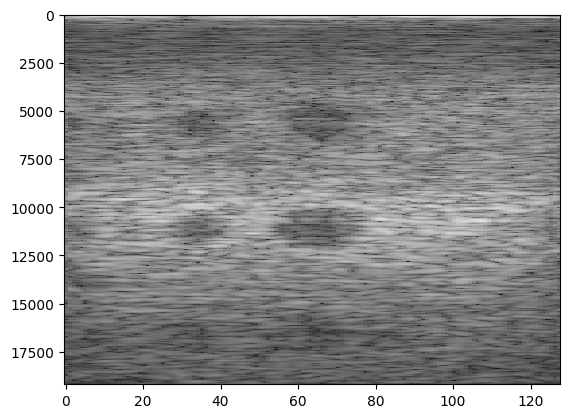

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

In [107]:
no_focal_points=5
wavelength=1452/(5.208*10**6)
distance=[5*wavelength+((x*1452)/2) for x in time_range_upsampled] #Time_range
for idx in range(0,len(distance),math.floor(len(distance)/no_focal_points)):

    element_spacing=0.298*10**-3
    n_elements=128
    beam_spacing=0.298*10**-3
    focal_length=distance[idx]
    d=0.75*10**-2


    x = np.linspace(-np.pi,np.pi,51) 
    apodization=np.cos(x)

    
    image=distance_delay_upsample_offset_apodization_sum(element_spacing,n_elements, beam_spacing, focal_length,d,apodization,left_right=False)
    image=tgc(image)
    image=envelope_detection(image)
    image=log_compression(image,comp_val)
    
    if idx==len(distance)-math.floor(len(distance)/no_focal_points)-1:
        end=math.floor(len(distance)/no_focal_points)+2
    else:
        end=math.floor(len(distance)/no_focal_points)+1
        
    #Last Row
    if idx==len(distance)-1:
        break
        

    #Storing the parts
    if idx==0:     
        mergered_image=image[idx:idx+end-1,:]
    else:
        
        mergered_image=np.vstack((mergered_image,image[idx:idx+end-1,:]))
        
    print("Focal Length: ", str(focal_length))
    plt.imshow(image, interpolation='nearest', aspect='auto', cmap='gray')
    plt.show()

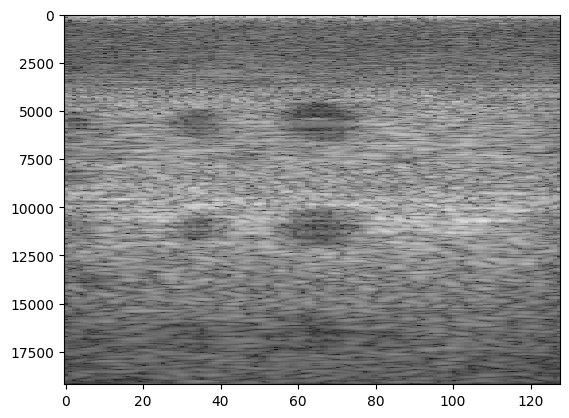

In [108]:
plt.imshow(mergered_image, interpolation='nearest', aspect='auto', cmap='gray')



# Raised Cosine Apodization

In [89]:
SPS=26
span=1
beta=1
nList = np.arange(-span*SPS,(span*SPS)+1)


weights = np.zeros(len(nList))


for index in range(len(nList)):
    n = nList[index]
    if (n == 0):
        weights[index] = (1/np.sqrt(SPS))*((1-beta) + (4*beta/np.pi))
    elif (np.abs(n*4*beta) == SPS):
        weights[index] = (beta/np.sqrt(2*SPS))*( (1+(2/np.pi))*np.sin(np.pi/(4*beta)) + (1-(2/np.pi))*np.cos(np.pi/(4*beta)) )
    else:
        weights[index] = (1/np.sqrt(SPS))*( (np.sin(np.pi*n*(1-beta)/SPS)) + (4*beta*n/SPS)*(np.cos(np.pi*n*(1+beta)/SPS)) ) / ( (np.pi*n/SPS) * (1 - (4*beta*n/SPS)**2) )
old_min=weights.min()
old_max=weights.max()
apodization = [( (x - old_min) / (old_max - old_min) ) * (1 - 0.5) + 0.5 for x in weights]
image=distance_delay_upsample_offset_apodization_sum(element_spacing,n_elements, beam_spacing, focal_length,d,apodization,left_right=False)

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

In [90]:
image=tgc(image)
image=envelope_detection(image)

image=log_compression(image,comp_val)



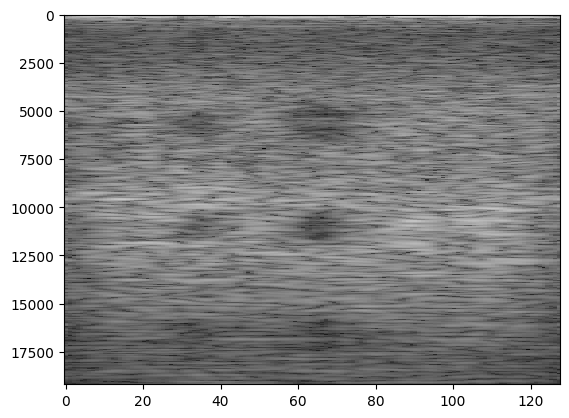

In [91]:
plt.imshow(image, interpolation='nearest', aspect='auto', cmap='gray')

## Apodization with dynamic

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

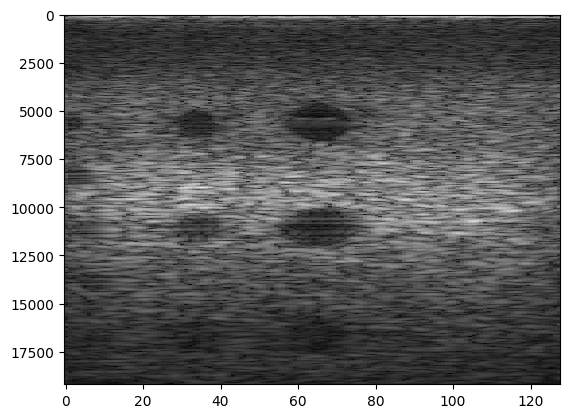

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

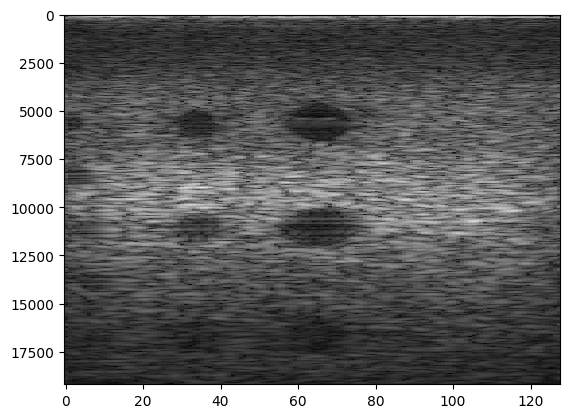

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

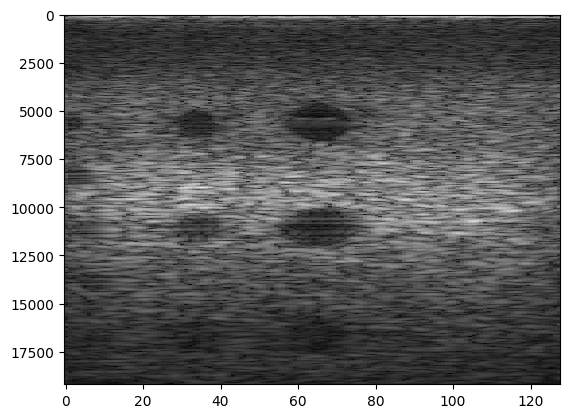

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

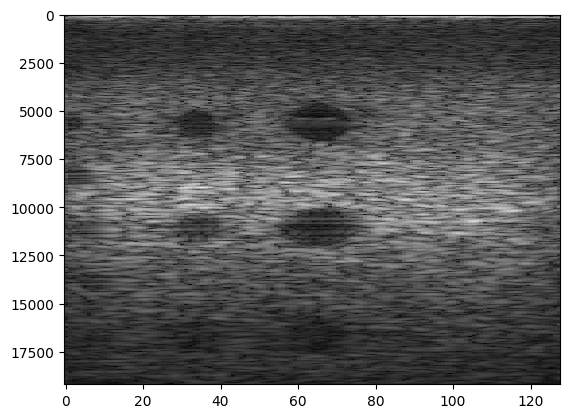

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

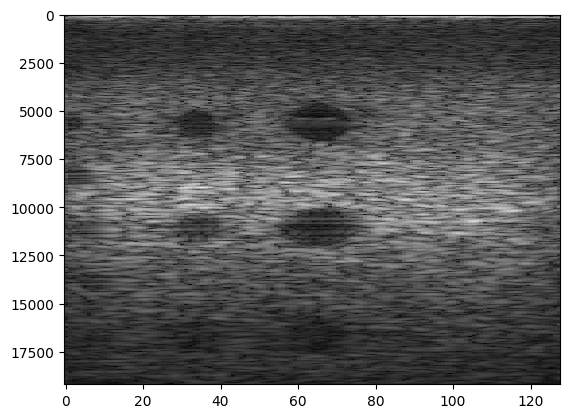

(26, 19191)
(27, 19191)
(28, 19191)
(29, 19191)
(30, 19191)
(31, 19191)
(32, 19191)
(33, 19191)
(34, 19191)
(35, 19191)
(36, 19191)
(37, 19191)
(38, 19191)
(39, 19191)
(40, 19191)
(41, 19191)
(42, 19191)
(43, 19191)
(44, 19191)
(45, 19191)
(46, 19191)
(47, 19191)
(48, 19191)
(49, 19191)
(50, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51, 19191)
(51,

In [117]:
no_focal_points=5
wavelength=1452/(5.208*10**6)
distance=[5*wavelength+((x*1452)/2) for x in time_range_upsampled] #Time_range

SPS=26
span=1
beta=1
nList = np.arange(-span*SPS,(span*SPS)+1)


weights = np.zeros(len(nList))


for index in range(len(nList)):
    n = nList[index]
    if (n == 0):
        weights[index] = (1/np.sqrt(SPS))*((1-beta) + (4*beta/np.pi))
    elif (np.abs(n*4*beta) == SPS):
        weights[index] = (beta/np.sqrt(2*SPS))*( (1+(2/np.pi))*np.sin(np.pi/(4*beta)) + (1-(2/np.pi))*np.cos(np.pi/(4*beta)) )
    else:
        weights[index] = (1/np.sqrt(SPS))*( (np.sin(np.pi*n*(1-beta)/SPS)) + (4*beta*n/SPS)*(np.cos(np.pi*n*(1+beta)/SPS)) ) / ( (np.pi*n/SPS) * (1 - (4*beta*n/SPS)**2) )
old_min=weights.min()
old_max=weights.max()
apodization = [( (x - old_min) / (old_max - old_min) ) * (1 - 0.5) + 0.5 for x in weights]


for idx in range(0,len(distance),math.floor(len(distance)/no_focal_points)):


    
    image=distance_delay_upsample_offset_apodization_sum(element_spacing,n_elements, beam_spacing, focal_length,d,apodization,left_right=False)
    
    image=tgc(image)
    image=envelope_detection(image)
    image=log_compression(image,0.4)
    
    if idx==len(distance)-math.floor(len(distance)/no_focal_points)-1:
        end=math.floor(len(distance)/no_focal_points)+2
    else:
        end=math.floor(len(distance)/no_focal_points)+1
        
    #Last Row
    if idx==len(distance)-1:
        break
        

    #Storing the parts
    if idx==0:     
        mergered_image=image[idx:idx+end-1,:]
    else:
        
        mergered_image=np.vstack((mergered_image,image[idx:idx+end-1,:]))
        
    print("Focal Length: ", str(focal_length))
    plt.imshow(image, interpolation='nearest', aspect='auto', cmap='gray')
    plt.show()

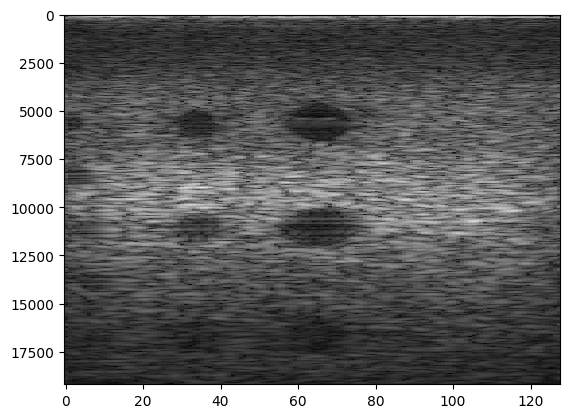

In [118]:
plt.imshow(mergered_image, interpolation='nearest', aspect='auto', cmap='gray')



In [122]:
contrast=mergered_image.max()-mergered_image.min()

In [135]:
mergered_photo=mergered_image*255

In [136]:
from PIL import Image, ImageStat

In [137]:
pilImage = Image.fromarray(mergered_photo)

In [138]:
contrast=np.array(pilImage).max()-np.array(pilImage).min()
contrast

251.64267

In [143]:
np.array(pilImage).min()

3.3573267

In [144]:
stat = ImageStat.Stat(pilImage)
contrast/stat.stddev

array([7.24529254])

# Fixed receive focus image of the transmit beam profile for the central transmit beam

In [38]:
data['rf'][:,:,63]

array([[ 14,  16,  28, ...,  28,  24,  19],
       [ 10,  18,  30, ...,  33,  33,  20],
       [-11,  -9, -20, ..., -21, -16, -14],
       ...,
       [-13,  -9,   0, ..., -11,  -2,  -8],
       [-17, -20, -17, ...,   1,   7,   6],
       [  3,  -4,  -8, ...,  10,   8,   8]], dtype=int16)

In [39]:
import math

def distance_delay_upsample_mid_offset_sum(element_spacing, n_elements, beam_spacing, focal_length,d):
    count=0
    upsampling_factor=10
    final_image=[]
    mid=63
    for line in range(0,128):

        if line==mid:
            distance=focal_length
        else:
            distance=math.sqrt((np.abs(mid-line)*element_spacing)**2 + (focal_length)**2)
        
        #NOW I HAVE THE DISTANCES FOR THE RESPECTIVE ELEMENTS TO THE FOCAL LENGTH FOR EACH ELEMENT TO SPECIFIC LINE "LINE"

        #STORED IN DISTANCES

        #NOW CALCULATING THE DELTA DISTANCE USED TO CALCULATE THE DELAY
        delta_x= distance-focal_length
        #NOW CALCULATING THE TIME DELAY TO FOCAL POINT FOR ALL THE SPECIFIC ELEMENTS TO THAT POINT
        time_from_focal=delta_x/1452


        #UPSAMPLING THE DATA BY A FACTOR OF 10

        data_points_upsampled=[]
        time_range_upsampled=[]

        for i in range(len(data['rf'])):
            data_points_upsampled.append(data['rf'][:,line,mid][i])
            time_range_upsampled.append(time_range[i])
            if i == len(data['rf'])-1:
                break
            new_point=data['rf'][:,line,mid][i]
            
            new_time=time_range[i]
            delta=(data['rf'][:,line,mid][i+1]-data['rf'][:,line,mid][i])/upsampling_factor
            delta_time=(time_range[i+1]-time_range[i])/upsampling_factor

            for _ in range(upsampling_factor-1):
                new_point=new_point+delta
                new_time=new_time+delta_time
                data_points_upsampled.append(new_point)
                time_range_upsampled.append(new_time)

        final_data_points_upsampled=np.array(data_points_upsampled).T
 

        #OFFSETTING THE SIGNAL

        time_range_upsampled = np.asarray(time_range_upsampled)
        idx = (np.abs(time_range_upsampled - time_from_focal)).argmin()

        temp=final_data_points_upsampled[idx:]
        final_image=np.pad(temp, (0, idx), 'constant')


        #SUMMATION of the respective element signals 
        #final_image.append(final.sum(axis=0))

        temp=final_image.reshape(final_data_points_upsampled.shape[0],1)
        if line==0:
            image=temp
        else:
            image=image.reshape(image.shape[0],image.shape[1])
            image=np.hstack((image, temp))
    return image



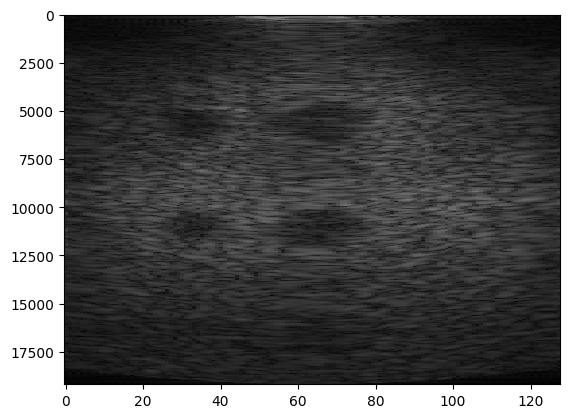

In [42]:
element_spacing=0.298*10**-3
n_elements=128
beam_spacing=0.298*10**-3
focal_length=2.8*10**-2
d=0.75*10**-2



image=distance_delay_upsample_mid_offset_sum(element_spacing,n_elements, beam_spacing, focal_length,d)
image=tgc(image)
image=envelope_detection(image)
image=log_compression(image,comp_val)



plt.imshow(image, interpolation='nearest', aspect='auto', cmap='gray')